In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time

# add the path to my packages to system paths so they can be imported
import sys
sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages')
# sys.path.append('F:\MAScThesis\code\my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

# import compare_with_benchmark as bn
import my_simgraph_06 as sg
import data_handler_01 as dh

# Load spike data

Spike data shape:  (297, 1141, 113) $\implies$ (movie repeats, frames/time, neurons)
<br>
Labels are 1 (= spike) or -1 (= no spike).

In [2]:
# load all spike data from file
spikes_dp = '../../../data/original_files/spikes.csv'
binned_data = np.loadtxt(spikes_dp, delimiter=',')
binned_data = binned_data.reshape(binned_data.shape[0], 1141, 113)
binned_data = binned_data * 2 - 1     # turn labels from 0,1 to -1,1

I_order_10 = [54, 35, 10, 60, 74, 9, 61, 56, 91, 104]

## Group all 113 neurons

This will create a more balanced dataset which is presumabley easier to solve.
<br>
Grouped data shape:  (297, 1141, 1) $\implies$ (movie repeats, frames/time, group)

In [3]:
# group all neurons together
grouped_data = np.zeros((297, 1141, 1))
for trial in range(297):
    for frame in range(1141):
        grouped_data[trial, frame, :] = 2 * int((binned_data[trial, frame, :] == 1).any()) - 1

In [4]:
# print some statistics
print('grouped_data.shape = ', grouped_data.shape)

avg_spike_perc = 0
print('trial #    | percentage belonging to class 1')
print('---------------------------------------------')
for trial in range(10):
    pers = dh.class_percentages(grouped_data[trial, :, :].reshape(-1), [-1, 1])
    avg_spike_perc += pers[1]
    print('trial #{:3} | {:.2f} %'.format(trial, pers[1]))

avg_spike_perc /= 10
print('---------------------------------------------')
print('AVERAGE     | {:.2f} %'.format(avg_spike_perc))

total_perc = np.sum(grouped_data == 1) *100 /(grouped_data.shape[0] * grouped_data.shape[1])
print('---------------------------------------------')
print('{:.2f} % of the whole data belongs to class 1.'.format(total_perc))

grouped_data.shape =  (297, 1141, 1)
trial #    | percentage belonging to class 1
---------------------------------------------
trial #  0 | 66.26 %
trial #  1 | 69.06 %
trial #  2 | 67.92 %
trial #  3 | 71.08 %
trial #  4 | 68.97 %
trial #  5 | 68.27 %
trial #  6 | 66.87 %
trial #  7 | 65.82 %
trial #  8 | 67.66 %
trial #  9 | 68.19 %
---------------------------------------------
AVERAGE     | 68.01 %
---------------------------------------------
68.47 % of the whole data belongs to class 1.


# Create training and validation datasets

In [5]:
# only consider the second trial
ind_min = 1*1141+0
ind_max = 2*1141-1
# train_num = int(data_num*0.8)
# val_num = data_num - train_num
train_num = 300
val_num = 10

def transform(fv):
    """
    Transform to be applied on feature vectors.
    
    Input: fv
    fv - 1xDf torch tensor representing a feature vector
    
    Output: fvv
    fvv - 1xDf' torch tensor representing the transformed feature vector
    """
    
    # for faster run and less memory usage
    fvv = fv[:, ::10]
    
    # for numerical stability during GD
    # fvv = fvv * 10
    
    return fvv

data_params = {'func': dh.datapoint_torch, 'lbl_func': dh.get_labels, 'features_dp': '../../../data/features/slowfast/slowfast_4732/', \
               'spike_data': grouped_data, 'group_id': 0, 'transform': transform}

train_num, val_num, train_data, val_data = \
dh.random_train_val_balanced(train_num, val_num, ind_min, ind_max, data_params, seed=1342)

# show statistics
print('train_num = ', train_num, ', val_num = ', val_num)
print('training data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(train_data['lbls'] == 1), np.sum(train_data['lbls'] == 1)*100/train_num))
print('validation data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(val_data['lbls'] == 1), np.sum(val_data['lbls'] == 1)*100/val_num))

# print('train_smpls = ', train_data['smpls'], '\nval_smpls = ', val_data['smpls'])
# print('train_lbls = ', train_data['lbls'], '\nval_lbls = ', val_data['lbls'])
# print('train_des = ', train_data['des'], '\nval_des = ', val_data['des'])

train_num =  300 , val_num =  10
training data contains 150 points (50.00%) of label 1.
validation data contains 5 points (50.00%) of label 1.


## Normalize feature vectors

Taken from 'code/03_mnist/sift_on_mnist/sift_on_mnist_06.ipynb' with small changes.

In [6]:
# train_dess_nrm = dh.normalize(train_data['des'], feature_nrm=1, node_nrm=30)  
# val_dess_nrm = dh.normalize(val_data['des'], feature_nrm=1, node_nrm=30)

## snippet to update a set (training or validation)

In [7]:
# # update the validation set, so that it doesn't overlap with the training or the previous validation set
# val_num = 10
# minus_set = np.append(val_data['smpls'], train_data['smpls'])
# val_num, val_smpls = dh.update_indices(val_num, ind_min, ind_max, minus_set, seed=None)
# val_dess, val_lbls = dh.update_set(val_smpls, data_params)
# val_data   = {'des': val_dess, 'lbls': val_lbls, 'smpls': val_smpls}

# # show statistics
# print('new val_num = ', val_num)
# print('validation data contains {} points ({:.2f}%) of label 1.'
#       .format(np.sum(val_data['lbls'] == 1), np.sum(val_data['lbls'] == 1)*100/val_num))
# # print('val_smpls = ', val_data['smpls'])
# # print('val_lbls = ', val_data['lbls'])
# # print('val_des = ', val_data['des'])

# Learn the similarity graph

In [8]:
# reload sg package
import importlib
importlib.reload(sg)

<module 'my_simgraph_06' from '/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages/my_simgraph_06.py'>

In [9]:
# graph construction and penalty term parameters
sg_params = {'mu': 30, 'Dt': 2, 'Dv':1, 'Dvt':1, \
             'cnstr_method_tt': 'time', 'cnstr_method_vv': 'time', 'cnstr_method_vt': 'time',\
             'train_t': train_data['smpls'], 'val_t': val_data['smpls'], \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters
sg_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 2, \
                  'num_its':10, 'check_freq':1, 'print_checks':True, 'Theta0':None, \
                  'force_all_its': True, 'threshold': 0.01}

time0 = time.time()
B, sg_stats = sg.fit_graph(dess=train_data['des'], lbls=train_data['lbls'], graph_params=sg_params, opt_params=sg_opt_params, seed=0)
print('Elapsed time = {} sec'.format(time.time()-time0))

Number of training datapoints: 300
Number of features for each point: 474
mu = 30
   0: eps = 7.81e-03;  train loss (E) = 742.29
   1: eps = 1.56e-02;  train loss (E) = 608.53
   2: eps = 1.95e-03;  train loss (E) = 490.77
   3: eps = 3.91e-03;  train loss (E) = 347.25
   4: eps = 7.81e-03;  train loss (E) = 215.02
   5: eps = 7.81e-03;  train loss (E) = 185.55
   6: eps = 7.81e-03;  train loss (E) = 179.48
   7: eps = 7.81e-03;  train loss (E) = 177.53
   8: eps = 7.81e-03;  train loss (E) = 177.14
   9: eps = 7.81e-03;  train loss (E) = 176.81
Elapsed time = 4.5228331089019775 sec


## Display learned metric matrix

Coordinates of elements with higher values than 0.0779355360083931
[(386, 61), (148, 148), (386, 148), (217, 217), (231, 231), (386, 248), (327, 327), (334, 334), (386, 369), (61, 386), (148, 386), (248, 386), (369, 386), (386, 386), (438, 386), (386, 438), (451, 451)]


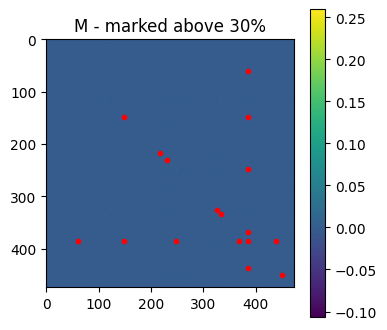

In [10]:
# display learned M
M = B.T @ B
# to preserve memory, uncomment below line
# del B

sg.display_matrix(M, None)

# mark elements with high values
thresh = 30
lim = (thresh/100) * np.max(M) # marker threshold
f_sz = M.shape[0]
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
plt.plot(xloc[M > lim],yloc[M > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M - marked above {}%'.format(thresh))
print('Coordinates of elements with higher values than {}'.format(lim))
print(list(zip(xloc[M > lim],yloc[M > lim])))

# save results
# plt.savefig('../../../data/experiments/slowfast/slowfast_sg/temp/finalM_'+str(0)+'.png')
# plt.close()
# np.savetxt('results/sg_finalB.csv', B, delimiter=',')

# Validate the similarity graph

In [11]:
M = B.T @ B
val_acc, y_est, t = sg.get_acc(M, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], sg_params, seed=0, show_edges=True)

edges between val. nodes:
 [(0, 6), (1, 7), (2, 4), (3, 9), (5, 8)]
edges between val. and train. nodes:
 [(0, 290), (0, 119), (1, 240), (1, 32), (2, 292), (2, 21), (3, 184), (3, 15), (4, 243), (4, 121), (5, 216), (5, 32), (6, 217), (6, 132), (7, 216), (7, 32), (8, 151), (8, 6), (9, 153), (9, 43)]


In [12]:
print('val acc = {:.2f}%'.format(val_acc*100))
print('elapsed time = {:.2f} ms'.format(t*1000))
print('estimated val labels = ', 2*(y_est>0).astype(np.int32)-1)

# # save results
# np.savetxt('results/sg_val_acc.txt', np.array([acc]))
# np.savetxt('results/sg_y_est.csv', y_est, delimiter=',')

val acc = 80.00%
elapsed time = 3.63 ms
estimated val labels =  [ 1 -1 -1  1  1 -1 -1 -1 -1 -1]


In [13]:
# comparing estimated and real spike locations
val_loc = np.arange(val_num)
val_spikes = val_loc[val_data['lbls']==1]
est_spikes = val_loc[y_est > 0]

if sum(val_data['lbls']==1) == 0:
    missed = 0
else:
    missed = sum(np.logical_and(val_data['lbls']==1, y_est < 0))/sum(val_data['lbls']==1)

if sum(val_data['lbls']==-1) == 0:
    false_alarm = 0
else:
    false_alarm = sum(np.logical_and(val_data['lbls']==-1, y_est > 0))/sum(val_data['lbls']==-1)

nospk_per = np.sum(val_data['lbls']==-1)/val_num
min_acc = max(nospk_per, 1-nospk_per)

print('Estimated spike time bins: ', est_spikes)
print('Real spike time bins: ', val_spikes)
print('{:.2f}% of validation points have label {} (= min accuracy)'.format(min_acc*100, -1 if nospk_per > 50 else 1))
print('Missed spikes (/all spikes): {:.2f}%'.format(missed*100))
print('False spikes (/all no-spike bins): {:.2f}%'.format(false_alarm*100))

Estimated spike time bins:  [0 3 4]
Real spike time bins:  [0 1 2 3 4]
50.00% of validation points have label 1 (= min accuracy)
Missed spikes (/all spikes): 40.00%
False spikes (/all no-spike bins): 0.00%


## Save validation results

In [14]:
# # prepare results file
# with open('../../data/slowfast_results/sg_4732_res_1.txt', 'w') as file:    
#     arr = ('{:^10} | {:^10} | {:^10} | {:^10} | {:^10} | {:^17} | {:^17} \n'\
#            .format('i', 'train_num', 'val_num', 'min_acc(%)', 'val_acc(%)',\
#                    'missed spks(%)', 'false alarms(%)'),'-'*101+'\n')
#     file.writelines(arr)

# # save the experiment's results
# with open('../../data/slowfast_results/sg_4732_res_1.txt', 'a') as file:
#     file.write('{:^10} | {:^10} | {:^10} | {:^10.2f} | {:^10.2f} | {:^17.2f} | {:^17.2f} \n'\
#                .format(0, train_num, val_num, min_acc*100, val_acc*100, missed*100, false_alarm*100))

# Show statistics

Text(0.5, 1.0, 'Time spent to find a valid stepsize in each iteration')

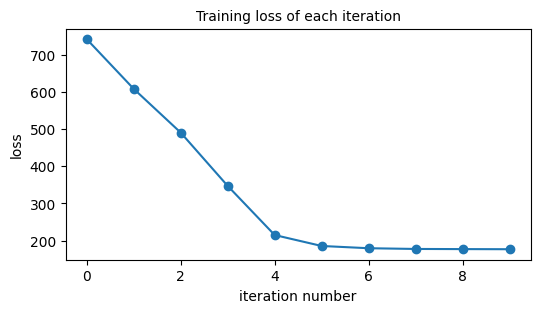

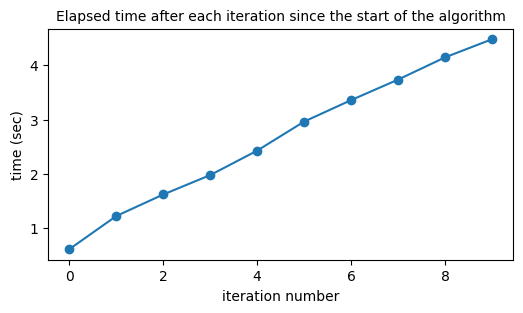

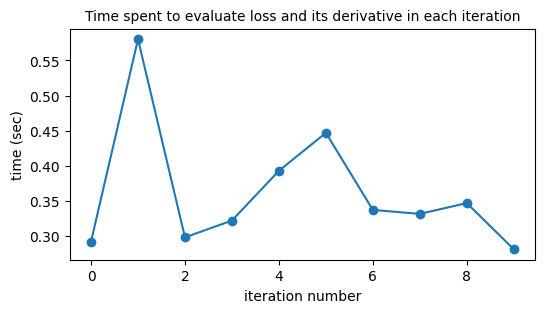

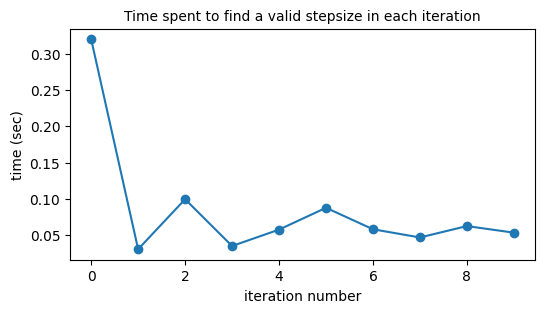

In [15]:
# Some informative figures to compare forced and flexible time complexity
plt.figure(figsize=(6,3))
plt.plot(sg_stats['train_losss'], marker='o')
plt.xlabel('iteration number')
plt.ylabel('loss')
plt.title('Training loss of each iteration', fontsize=10)
# plt.savefig('results/sg_trainlosss.png')

plt.figure(figsize=(6,3))
plt.plot(sg_stats['it_times'], marker='o')
plt.xlabel('iteration number')
plt.ylabel('time (sec)')
plt.title('Elapsed time after each iteration since the start of the algorithm', fontsize=10)
# plt.savefig('results/sg_runtime.png')

plt.figure(figsize=(6,3))
plt.plot(sg_stats['eval_times'], marker='o')
plt.xlabel('iteration number')
plt.ylabel('time (sec)')
plt.title('Time spent to evaluate loss and its derivative in each iteration', fontsize=10)
# plt.savefig('results/sg_evallosstime.png')

plt.figure(figsize=(6,3))
plt.plot(sg_stats['stepsizeloop_times'], marker='o')
plt.xlabel('iteration number')
plt.ylabel('time (sec)')
plt.title('Time spent to find a valid stepsize in each iteration', fontsize=10)
# plt.savefig('results/sg_epsilontime.png')

M entries range from -0.10661 to 0.25979


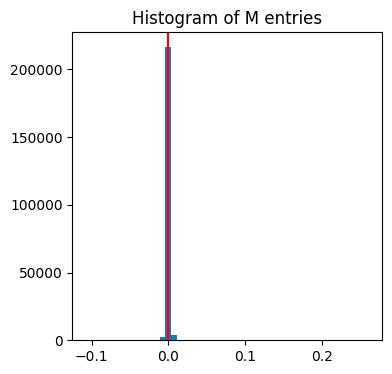

In [16]:
sg.hist_of_entries(M, 50, zeroline=True, peakline=True)
plt.title('Histogram of M entries')

print('M entries range from {:.5f} to {:.5f}'.format(np.min(M), np.max(M)))